In [4]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS


import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* model user arrival as poisson process 
* half dataset - consider only movies within that half of time 
* want to have new users - cold start problem 
* whenever spare updates - gradient updates and ALS solves 
* if past gradient was large - prioritize that update 
* movielens 1M is probably fine 
* SGD on one user - SGD on all the items (then until convergence?)

1. just update the user 
2. allow for movie updates - update until convergence? (user, movie that the user clicked on, etc.) 
3. beginning of them (nothing for anything) 

In [2]:
#dataset_dir = use_dataset("ml-100k")
#dataset_dir = use_dataset("ml-latest-small")
dataset_dir = use_dataset("ml-25m")

/data/wooders/ralf-vldb//datasets/ml-25m


In [3]:
#ratings_path = f"{dataset_dir}/u.data"
ratings_path = f"{dataset_dir}/ratings.csv"
#df = pd.read_csv(ratings_path, sep = '\t', names = ["user_id", "movie_id", "rating", "timestamp"]).sort_values('timestamp')
df = pd.read_csv(ratings_path) #, names = ["userId", "movieId", "rating", "timestamp"])
df.columns = ["user_id", "movie_id", "rating", "timestamp"]
df

,user_id,movie_id,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [14]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [15]:
df

,user_id,movie_id,rating,timestamp,datetime
0,1,296,5.0,1147880044,2006-05-17 15:34:04
1,1,306,3.5,1147868817,2006-05-17 12:26:57
2,1,307,5.0,1147868828,2006-05-17 12:27:08
3,1,665,5.0,1147878820,2006-05-17 15:13:40
4,1,899,3.5,1147868510,2006-05-17 12:21:50
...,...,...,...,...,...
25000090,162541,50872,4.5,1240953372,2009-04-28 21:16:12
25000091,162541,55768,2.5,1240951998,2009-04-28 20:53:18
25000092,162541,56176,2.0,1240950697,2009-04-28 20:31:37
25000093,162541,58559,4.0,1240953434,2009-04-28 21:17:14


In [7]:
df_small = df.head(10)

In [11]:
pd.to_datetime(df_small['timestamp'],unit='s')

0   2006-05-17 15:34:04
1   2006-05-17 12:26:57
2   2006-05-17 12:27:08
3   2006-05-17 15:13:40
4   2006-05-17 12:21:50
5   2006-05-17 12:21:35
6   2006-05-17 12:27:06
7   2006-05-17 15:05:26
8   2006-05-17 12:27:19
9   2006-05-17 12:20:14
Name: timestamp, dtype: datetime64[ns]

In [18]:
df.datetime.min()

Timestamp('1995-01-09 11:46:49')

In [19]:
df.datetime.max()

Timestamp('2019-11-21 09:15:03')

In [21]:
df[df["user_id"] == 1].datetime.min()

Timestamp('2006-05-17 12:14:13')

In [22]:
df[df["user_id"] == 1].datetime.max()

Timestamp('2006-05-17 15:34:15')

In [24]:
user_range = df.groupby("user_id").datetime.max() - df.groupby("user_id").datetime.min()

In [34]:
user_range

user_id
1           0 days 03:20:02
2           0 days 00:41:39
3        1465 days 12:08:04
4           2 days 23:40:10
5         322 days 05:57:46
                ...        
162537      0 days 00:18:06
162538      0 days 01:21:11
162539      0 days 00:17:48
162540      2 days 00:33:26
162541      0 days 01:57:22
Name: datetime, Length: 162541, dtype: timedelta64[ns]

In [39]:
user_range.sort_values()

user_id
85727       0 days 00:00:00
107927      0 days 00:00:00
16603       0 days 00:00:00
65824       0 days 00:00:00
121119      0 days 00:00:00
                ...        
121934   8045 days 22:22:37
62383    8067 days 22:35:30
107681   8068 days 23:41:00
39415    8077 days 17:07:31
39905    8101 days 08:33:56
Name: datetime, Length: 162541, dtype: timedelta64[ns]

In [68]:
df_time_sorted = df.sort_values(by="datetime")

In [69]:
df_time_sorted

,user_id,movie_id,rating,timestamp,datetime
326761,2262,21,3.0,789652009,1995-01-09 11:46:49
326810,2262,1079,3.0,789652009,1995-01-09 11:46:49
326767,2262,47,5.0,789652009,1995-01-09 11:46:49
15845015,102689,1,4.0,822873600,1996-01-29 00:00:00
15845023,102689,39,5.0,822873600,1996-01-29 00:00:00
...,...,...,...,...,...
13207880,85523,168252,4.0,1574327479,2019-11-21 09:11:19
1284508,8642,202101,2.0,1574327512,2019-11-21 09:11:52
13207893,85523,204704,4.0,1574327533,2019-11-21 09:12:13
1284464,8642,122914,4.0,1574327549,2019-11-21 09:12:29


<AxesSubplot:xlabel='datetime', ylabel='user_id'>

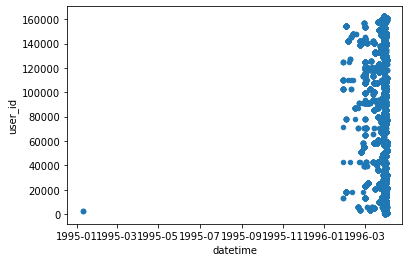

In [72]:
df_time_sorted.head(10000).plot.scatter(x="datetime", y="user_id")

<AxesSubplot:xlabel='datetime', ylabel='user_id'>

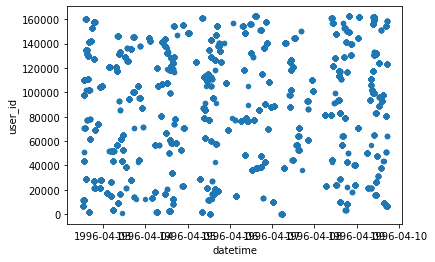

In [77]:
df_time_sorted.iloc[10000:20000].plot.scatter(x="datetime", y="user_id")

In [78]:
df[df["user_id"] == 2262]

,user_id,movie_id,rating,timestamp,datetime
326757,2262,1,5.0,852806429,1997-01-09 10:40:29
326758,2262,6,3.0,852809757,1997-01-09 11:35:57
326759,2262,9,2.0,852809531,1997-01-09 11:32:11
326760,2262,14,3.0,852806963,1997-01-09 10:49:23
326761,2262,21,3.0,789652009,1995-01-09 11:46:49
...,...,...,...,...,...
326814,2262,1198,4.0,852810527,1997-01-09 11:48:47
326815,2262,1356,4.0,852806794,1997-01-09 10:46:34
326816,2262,1357,5.0,852808661,1997-01-09 11:17:41
326817,2262,1419,3.0,852810136,1997-01-09 11:42:16


In [ ]:
users = list(set(df.user_id.tolist()))
user_start_ts = {user: df[df["user_id"] == user].timestamp.min() for user in users}
df.timestamp = df.apply(lambda x: x["timestamp"] - user_start_ts[x["user_id"]], axis=1)

In [ ]:
df = df.sort_values('timestamp')
df

In [88]:
df.timestamp.max() - df.timestamp.min() 

784675694

In [90]:
df.userId.value_counts()

72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
21443        20
45297        20
82652        20
30764        20
20369        20
Name: userId, Length: 162541, dtype: int64

In [79]:
df[df["user_id"] == 148].timestamp.max() - df[df["user_id"] == 148].timestamp.min()

385088

In [9]:
squash_amount = 100

In [39]:
new_timestamp = [i // squash_amount for i in range(1, len(df)+1)]

In [17]:
new_df = df.drop('timestamp', 1)
new_df['timestamp'] = new_timestamp

In [59]:
new_df[new_df["user_id"] == 148]

,user_id,movie_id,rating,timestamp
99336,148,194,5,125
33589,148,496,3,125
72245,148,174,5,125
12982,148,1039,2,125
46538,148,168,5,125
...,...,...,...,...
7784,148,473,5,142
99511,148,127,1,142
32257,148,151,4,142
7203,148,1012,4,142


## Train PySpark ALS Model 

In [19]:
def train_stream_test_split(df):
    columns = ["user_id", "movie_id", "rating", "timestamp"]
    als_data = []
    stream_data = []
    for user_id in df["user_id"].unique():
        user_df = df[df["user_id"] == user_id].sort_values("timestamp")
        count = 0
        for row in user_df.itertuples():
            data = [row.user_id, row.movie_id, row.rating, row.timestamp]
            if count < len(user_df) / 2:
                als_data.append(data)
            else:
                stream_data.append(data)
            count += 1
    als_df = pd.DataFrame(data=als_data, columns=columns).sort_values("timestamp")
    movie_list = set(als_df['movie_id'])
    stream_df = pd.DataFrame(data=stream_data, columns=columns).sort_values("timestamp")
    # Drop movies not seen before from stream
    stream_df = stream_df.drop(stream_df[stream_df['movie_id'].map(lambda x: x not in movie_list)].index)
    test_df = stream_df.copy()
    return als_df, stream_df, test_df

In [20]:
als_df, stream_df, test_df = train_stream_test_split(new_df)

In [21]:
spark = SparkSession.builder.master('local').appName('als').getOrCreate()

In [22]:
spark_als_df = spark.createDataFrame(als_df) 
spark_stream_df = spark.createDataFrame(stream_df)

In [24]:
als = ALS(
         userCol="user_id", 
         itemCol="movie_id",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop",
         rank=150,
         maxIter=10,
         regParam=.1
)

In [25]:
model=als.fit(spark_als_df)

In [26]:
predictions = model.transform(spark_stream_df)
evaluator = RegressionEvaluator().setMetricName("rmse").setLabelCol("rating").setPredictionCol("prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9815395865331437

## Save Features CSV

In [34]:
name = "ml-100k-features"
dataset_dir = read_config()["dataset_dir"] + "/" + name
dataset_dir

'/data/wooders/ralf-vldb//datasets/ml-100k-features'

In [36]:
model.itemFactors.toPandas().sort_values('id').to_csv(f'{dataset_dir}/movie_features.csv', index = False)
model.userFactors.toPandas().sort_values('id').to_csv(f'{dataset_dir}/user_features.csv', index = False)

In [37]:
stream_df = stream_df.sort_values('timestamp')
new_timestamp = [i // squash_amount for i in range(1, len(stream_df)+1)]
stream_df['timestamp'] = new_timestamp
print(len(stream_df))
stream_df.to_csv(f'{dataset_dir}/ratings.csv', index = False)

49442


In [38]:
log_dataset(name)

vldb/datasets ml-100k-features /ml-100k-features/ratings.csv
uploading /data/wooders/ralf-vldb//datasets/ml-100k-features vldb/datasets vldb/datasets/ml-100k-features/ratings.csv
vldb/datasets ml-100k-features /ml-100k-features/user_features.csv
uploading /data/wooders/ralf-vldb//datasets/ml-100k-features vldb/datasets vldb/datasets/ml-100k-features/user_features.csv
vldb/datasets ml-100k-features /ml-100k-features/movie_features.csv
uploading /data/wooders/ralf-vldb//datasets/ml-100k-features vldb/datasets vldb/datasets/ml-100k-features/movie_features.csv


'vldb/datasets/ml-100k-features'

In [41]:
stream_df[stream_df["user_id"] == 148]

,user_id,movie_id,rating,timestamp
8936,148,191,1,48
8938,148,169,5,48
8940,148,8,4,48
8941,148,501,4,48
8937,148,234,3,48
8939,148,596,5,48
8942,148,132,4,49
8963,148,181,5,55
8946,148,408,5,55
8962,148,1012,4,55
